In [1]:
import os
import random
import re
import time

import pandas as pd
import numpy as np
# import warnings
import warnings
import seaborn as sns
import os
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier 

import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# ignore warnings
warnings.filterwarnings("ignore")
# Any results you write to the current directory are saved as output.

## Primeiros Passos

- Este Dataset consiste em um conjunto de comentários feitos em uma loja de livros
    - O intuito será de criar um modelo para verificar se o comentário foi positivo ou negativo

- Criei duas classes para fazer o controle dos "sentimentos" positivos, negativos e neutros.

In [2]:
import random 
class Sentiment: #created this class to not pass strings into the return
    NEGATIVE = 'NEGATIVE'
    POSITIVE = 'POSITIVE'
    NEUTRAL = 'NEUTRAL'

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
    
    def get_sentiment(self):
        if self.score >= 4.0:
            return Sentiment.POSITIVE
        elif self.score == 3.0:
            return Sentiment.NEUTRAL
        else:
            return Sentiment.NEGATIVE
        
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
    
    def evenly_distributed(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive [:len(negative)]
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)
        

In [3]:
import json
file_name = './input/words_alg/sentiment/books_small_10000.json'
reviews = []
with open(file_name) as f:
    for line in f:
        review = json.loads(line) #using this i'll be able to transform in a dictionary
        reviews.append(Review(review['reviewText'], review['overall']))

### Visualizando

In [4]:
df = pd.DataFrame({'text': [x.text for x in reviews], 'Categoria' : [y.sentiment for y in reviews]
                  })
df.groupby('Categoria').count()

,text
Categoria,
NEGATIVE,644
NEUTRAL,978
POSITIVE,8378


- Como podemos ver, há muita discrepância nos valores dos 'sentimentos'.
- Para resolver isso, usarei um container para nivelar os valores absolutos

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #give more value to specific kind of words
#Container
cont = ReviewContainer(reviews)
cont.evenly_distributed()
df = pd.DataFrame({'text': [x.text for x in cont.reviews], 'Categoria' : [y.sentiment for y in cont.reviews]
                  })

In [6]:
df1 = df.groupby('Categoria').count()
df1.head()

,text
Categoria,
NEGATIVE,644
POSITIVE,644


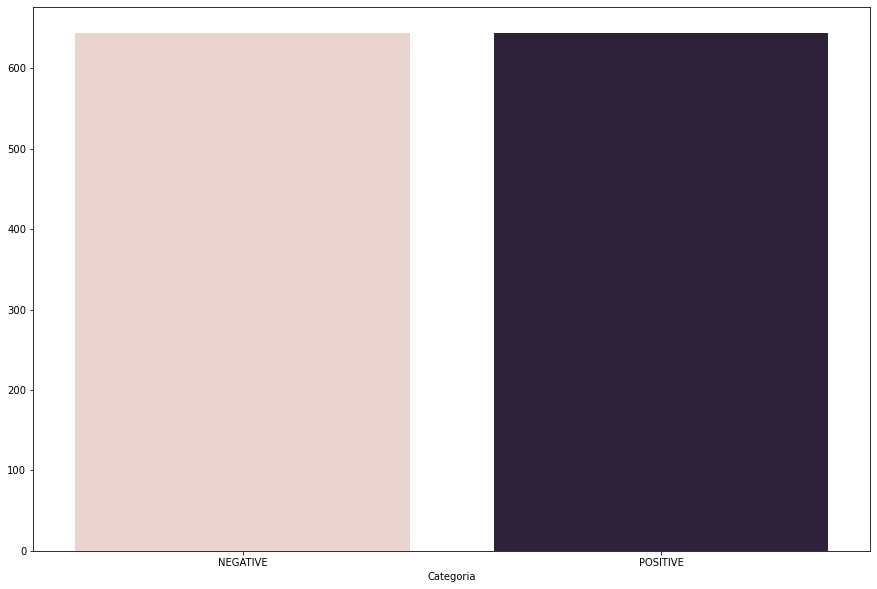

In [7]:
plt.figure(figsize=(15,10))
ax= sns.barplot(x=df1['text'].index, y=df1['text'].values,palette = sns.cubehelix_palette(len(df1.index)))

### Aplicando transformações no Dataset

Para ser possível modelar este dataset, preciso primeiramente converter os elementos da coluna 'text' em vetores

In [8]:
X1 = [x.text for x in cont.reviews]
y = [y.sentiment for y in cont.reviews]

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #give more value to specific kind of words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X1)

## Modelagem

- Primeiro, dividirei o dataset em dois: Train e Test
    - Servirá para, ao fazer a modelagem, poder testar o modelo em uma parte do dataset que não foi utilizado para a modelagem

In [22]:
N = len(df)
TRAIN_PERC = 0.8
ind_train = np.random.rand(N) < TRAIN_PERC
train, test = df[ind_train], df[~ind_train]
print(f'len(train)={len(train)}; len(test)={len(test)}')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.text)
X_train_counts.shape

X_test_counts = count_vect.transform(test.text)
X_test_counts.shape

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf.shape

len(train)=1026; len(test)=262


(262, 10405)

- Aqui inicio o processo de modelagem

In [23]:
clf_dict = {
    'LogisticRegression': LogisticRegression,
    'MultinomialNB': MultinomialNB,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'SGDClassifier': SGDClassifier,
    'Perceptron': Perceptron,
    'RidgeClassifier': RidgeClassifier,
    'LinearSVC': LinearSVC,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier,
    #'MLPClassifier': MLPClassifier,
}

In [24]:
def get_accuracy(clf, n_estimators=None, max_depth=None, learning_rate=None, max_iter=None):
    start = time.time()
    text_clf = clf(**params).fit(X_train_tfidf, train.Categoria)
    predicted = text_clf.predict(X_test_tfidf)
    print(f'Accuracy gets in {round(time.time()-start, 2)}s.')
    return np.mean(predicted == test.Categoria)

result_dict = {}

for clf_str, clf_fn in clf_dict.items():
    if clf_str == 'LogisticRegression':
        params = {'max_iter': 200}
    elif clf_str == 'RandomForestClassifier':
        params = {'n_estimators': 50,
                  'max_depth': 10}
    elif clf_str == 'DecisionTreeClassifier':
        params = {'max_depth': 10}
    elif clf_str == 'GradientBoostingClassifier':
        params = {'n_estimators': 50,
                  'learning_rate': 0.1}
    else:
        params = {}
    accuracy = get_accuracy(clf=clf_fn, **params)
    result_dict[clf_str] = accuracy
    print(f"Clf={clf_str}; Accuracy={accuracy}")

Accuracy gets in 0.1s.
Clf=LogisticRegression; Accuracy=0.8740458015267175
Accuracy gets in 0.0s.
Clf=MultinomialNB; Accuracy=0.8549618320610687
Accuracy gets in 0.11s.
Clf=DecisionTreeClassifier; Accuracy=0.7099236641221374
Accuracy gets in 0.0s.
Clf=SGDClassifier; Accuracy=0.8549618320610687
Accuracy gets in 0.0s.
Clf=Perceptron; Accuracy=0.8320610687022901
Accuracy gets in 0.01s.
Clf=RidgeClassifier; Accuracy=0.8549618320610687
Accuracy gets in 0.01s.
Clf=LinearSVC; Accuracy=0.8435114503816794
Accuracy gets in 0.17s.
Clf=RandomForestClassifier; Accuracy=0.8015267175572519
Accuracy gets in 1.32s.
Clf=GradientBoostingClassifier; Accuracy=0.7900763358778626


In [25]:
result_dict = {
    k: v
    for k, v in sorted(
        result_dict.items(),
        key=lambda x: x[1],
        reverse=True
    )
}

result_dict

{'LogisticRegression': 0.8740458015267175,
 'MultinomialNB': 0.8549618320610687,
 'SGDClassifier': 0.8549618320610687,
 'RidgeClassifier': 0.8549618320610687,
 'LinearSVC': 0.8435114503816794,
 'Perceptron': 0.8320610687022901,
 'RandomForestClassifier': 0.8015267175572519,
 'GradientBoostingClassifier': 0.7900763358778626,
 'DecisionTreeClassifier': 0.7099236641221374}

- Percebemos aqui valores aceitaveis sem fazer nenhuma optimização, chegando a 87% de precisão com LogisticRegression
- Agora, inicio os processos de optimização afim de verificar se existem melhores parametros à serem utilizados

In [26]:
DIM_Logistic = [
    Integer(100, 400, name='max_iter')
]

DIM_SVC = [
    Real(1e-5, 1, name='tol', prior='log-uniform'),
    Real(0.1, 1.5, name='C', prior='log-uniform')
]

DIM_SGDC = [
    Real(1e-5, 1e-2, name='alpha', prior='log-uniform')
]

DIM_RF = [
    Integer(1, 100, name='n_estimators'),
    Integer(5, 30, name='max_depth')
]

DIMS = {
    'LogisticRegression': DIM_Logistic,
    'LinearSVC': DIM_SVC,
    'SGDClassifier': DIM_SGDC,
    'RandomForestClassifier': DIM_RF
}

In [27]:
def optimize(clf_str='LinearSVC'):
    
    dimensions = DIMS[clf_str]
    print(dimensions)
    
    @use_named_args(dimensions=dimensions)
    def fitness(**params):
        clf = clf_dict[clf_str](**params)
        text_clf = clf.fit(X_train_tfidf, train.Categoria)
        predicted = text_clf.predict(X_test_tfidf)
        accuracy = np.mean(predicted == test.Categoria)
        print(f'accuracy={accuracy} with params={params}')
        return -1.0 * accuracy
    
    res = gp_minimize(func=fitness,
                      dimensions=dimensions,
                      acq_func='EI', # Expected Improvement.
                      n_calls=10,
                      random_state=666)
    print(f'best accuracy={-1.0 * res.fun} with {res.x}')
    return res

In [30]:
res_dict = {}
for clf_str, clf_dim in DIMS.items():
    print(f'start optimizaton for {clf_str}')
    res = optimize(clf_str=clf_str)
    res_dict[clf_str] = res

start optimizaton for LogisticRegression
[Integer(low=100, high=400, prior='uniform', transform='identity')]
accuracy=0.8740458015267175 with params={'max_iter': 131}
accuracy=0.8740458015267175 with params={'max_iter': 163}
accuracy=0.8740458015267175 with params={'max_iter': 139}
accuracy=0.8740458015267175 with params={'max_iter': 325}
accuracy=0.8740458015267175 with params={'max_iter': 201}
accuracy=0.8740458015267175 with params={'max_iter': 173}
accuracy=0.8740458015267175 with params={'max_iter': 178}
accuracy=0.8740458015267175 with params={'max_iter': 184}
accuracy=0.8740458015267175 with params={'max_iter': 239}
accuracy=0.8740458015267175 with params={'max_iter': 170}
best accuracy=0.8740458015267175 with [131]
start optimizaton for LinearSVC
[Real(low=1e-05, high=1, prior='log-uniform', transform='identity'), Real(low=0.1, high=1.5, prior='log-uniform', transform='identity')]
accuracy=0.8664122137404581 with params={'tol': 3.2590317060358435e-05, 'C': 0.17723383193111547}


In [31]:
for clf_str, res in res_dict.items():
    hyperparameters_label = [hp.name for hp in DIMS[clf_str]]
    best_hyperparameters = dict(zip(hyperparameters_label, res.x))
    print(f'clf={clf_str}\nbest accuracy={-res.fun}\nbest hyperparameters={best_hyperparameters}\n')

clf=LogisticRegression
best accuracy=0.8740458015267175
best hyperparameters={'max_iter': 131}

clf=LinearSVC
best accuracy=0.8664122137404581
best hyperparameters={'tol': 3.2590317060358435e-05, 'C': 0.17723383193111547}

clf=SGDClassifier
best accuracy=0.8625954198473282
best hyperparameters={'alpha': 0.0017823444328076245}

clf=RandomForestClassifier
best accuracy=0.8129770992366412
best hyperparameters={'n_estimators': 77, 'max_depth': 25}



## Conclusão

- O objetivo desse Kernel foi analisar e construir um modelo capaz de prever o padrão de texto em: descrições positivas e negativas.
- Este estudo pode se reproduzido em websites, e-commerces, blogs, etc afim de verificar a quantidade de comentários positivos e negativos de determinado produto ou seção
- Foi alcançado um percentual de 87.40% de precisão com apenas 1288 linhas de dados